In [10]:
import pandas as pd
import numpy as np
from tqdm import tqdm 

import matplotlib.pyplot as plt

In [12]:
dat = pd.read_csv("../data/reserve_demand_cruve_data.csv")
dep_var = 'Normalized'
main_indep_var= 'excess_reserve'
dep_var_name= 'Normalized Overnight Rate'
main_indep_var_name= 'Excess Reserve'

y = dat[dep_var]  
x = dat.drop(columns=[dep_var])
x_scaled  = (x-x.min())/(x.max()-x.min())  

In [3]:
from scipy.optimize import curve_fit
from scipy.special import erfinv
import inspect

logistic = lambda x, a, b, c, d : a + b /(1 - c*np.exp(d*x))
redLogistic = lambda x, a, b, c: a + 1 / (1 - b * np.exp(c*x))
fixLogistic = lambda x,a, b: a + 1 / (1 - np.exp(b*x))
doubleExp = lambda x, a, b ,c, d : a + b * np.exp(c * np.exp(d*x))
exponential = lambda x, a, b, c : a + b * np.exp(c*x)
fixExponential = lambda x, b, c: b * np.exp(c*x)
arctan = lambda x, a, b, c : a + b * np.arctan(c*x)
linear = lambda x, a, b: a+b*x

curve_func_d = {
'logistic': logistic,
'redLogistic': redLogistic,
'fixLogistic': fixLogistic,
'doubleExp': doubleExp,
'exponential': exponential,
'fixExponential': fixExponential,
'arctan': arctan,
'linear': linear}

def quantile_loss(func w, curvename, x, y, q):
        """Computes the quantile loss for curve fitting."""
        ypred = self.curve(x, w, curvename)
        e = y - ypred
        return np.maximum(q * e, (q - 1) * e).mean()

In [4]:
def plot_curve_with_confidence_interval(x_data, y_data, func, popt, popt_up=None, popt_down=None, q=0.9, ax = None):
    
    # Plot the data
    if ax is None:
        f, ax = plt.subplots(1, 1)
    
    ax.scatter(x_data, y_data, label='Data')

    # Plot the fitted function
    _x = x_data.sort_values()
    _ypred = func(_x, *popt)
    ax.plot(_x, _ypred, 'r-', label='Fitted function')

    if (popt_up is not None) & (popt_down is not None):
        # Plot the confidence interval
        _ydown = func(_x, *popt_down)
        _yup = func(_x, *popt_up)
        ax.fill_between(_x, _ydown, _yup, color='gray', alpha=0.5, label=f'{int(q*100)}% CI')
    ax.legend()
    return ax

In [25]:
xscale

1.0

In [28]:
excess_reserves = x[main_indep_var]
quantile_weights = 'Huber'
q = 0.9
xscale = 1/(excess_reserves.max()-excess_reserves.min())
param_mean_d = {}
param_up_d = {}
param_down_d = {}
param_cov_d = {}

for curvename, func in curve_func_d.items():
    num_params = len(inspect.signature(func).parameters) -1
    # initial parameters
    p0 = 0.1 * np.ones(num_params)
    p0 = np.zeros(num_params)
    #p0[-1] = -xscale
    # lower bound parameters
    lb = -20 * np.ones(num_params)
    lb[-1] =  -np.inf
    
    # upper bound parameters
    ub = 20 * np.ones(num_params)
    ub[-1] = 0
    # Fit the model
    popt, pcov = curve_fit(func, excess_reserves, y, p0, bounds = (lb, ub), method='trf', loss='soft_l1') 
    
    param_mean_d[curvename],  param_cov_d[curvename] = popt,  pcov

In [29]:
param_mean_d

{'logistic': array([ 3.16227766e-10,  3.16227766e-10,  0.00000000e+00, -1.00000000e-10]),
 'redLogistic': array([-3.16233710e-10, -3.16221822e-10, -1.00000000e-10]),
 'fixLogistic': array([-0.73543728, -0.00300948]),
 'doubleExp': array([ 3.16227766e-10,  3.16227766e-10,  0.00000000e+00, -1.00000000e-10]),
 'exponential': array([ 3.16229080e-10,  3.16226452e-10, -1.00000000e-10]),
 'fixExponential': array([ 4.47213595e-10, -1.00000000e-10]),
 'arctan': array([ 4.47213595e-10, -3.71537458e-15, -1.00000000e-10]),
 'linear': array([ 4.07038206e-01, -2.57095746e-07])}

KeyError: 'logistic'

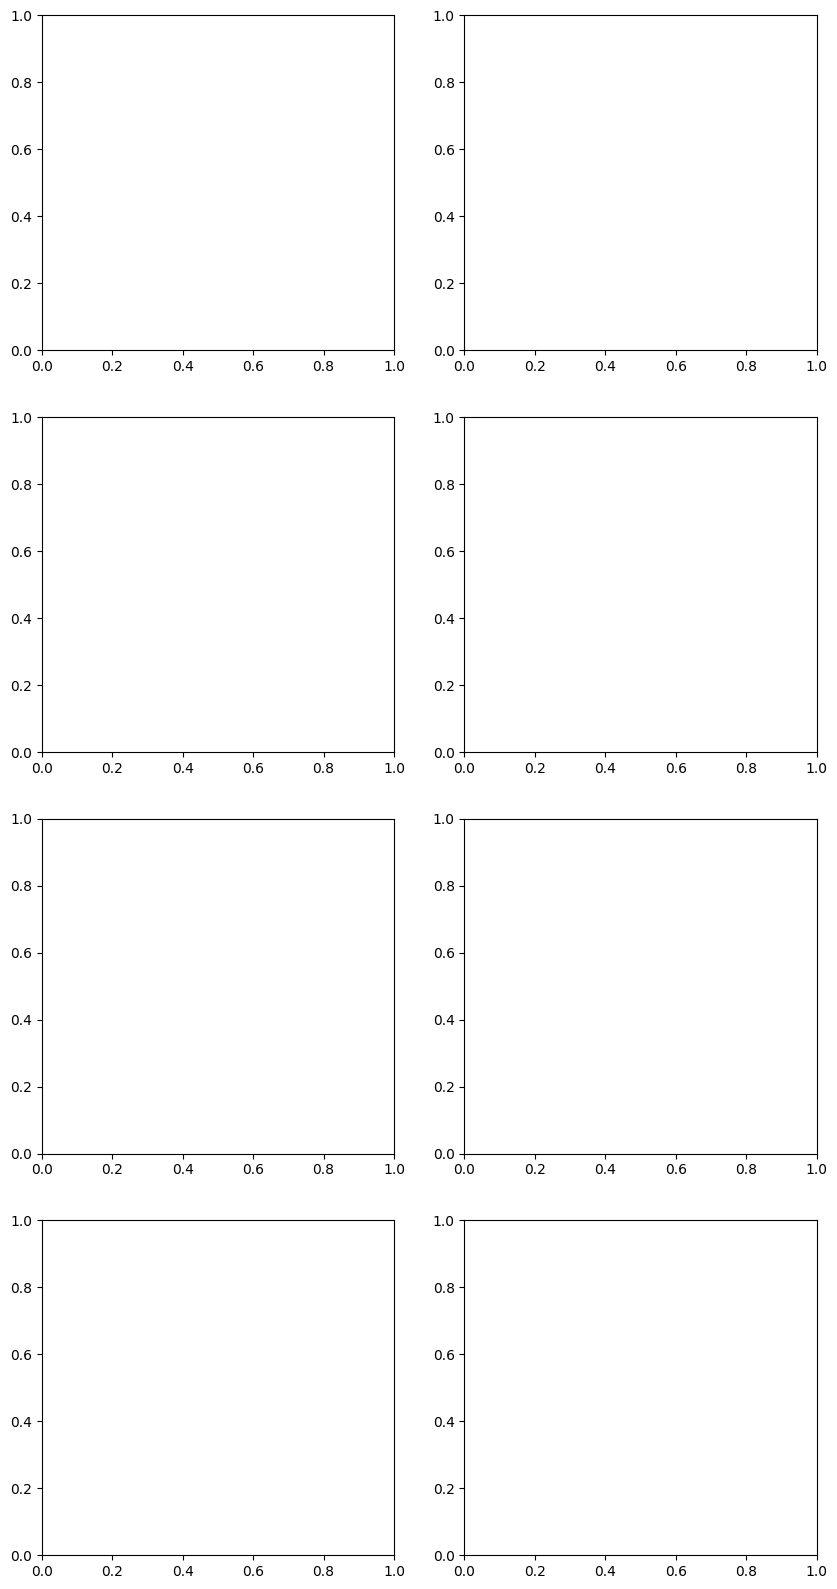

In [30]:
curves_l  = list(curve_func_d.keys())
nplots = len(curves_l) 
ncols = 2
nrows = int(np.ceil(nplots/ncols))
f, axes = plt.subplots(nrows,ncols, figsize = (ncols*5, nrows*5))
for i, curvename in enumerate(curves_l):
    ax = plt.subplot(nrows,ncols, i+1)
    plot_curve_with_confidence_interval(excess_reserves, y, 
                                        curve_func_d[curvename], param_mean_d[curvename], 
                                        param_up_d[curvename], param_down_d[curvename],
                                        q=0.9, ax = ax)
    ax.set_ylim([y.min()-0.1, y.max()+0.1])
    ax.set(title = curvename, xlabel='excess reserves', ylabel =dep_var_name)
plt.tight_layout()
plt.show()